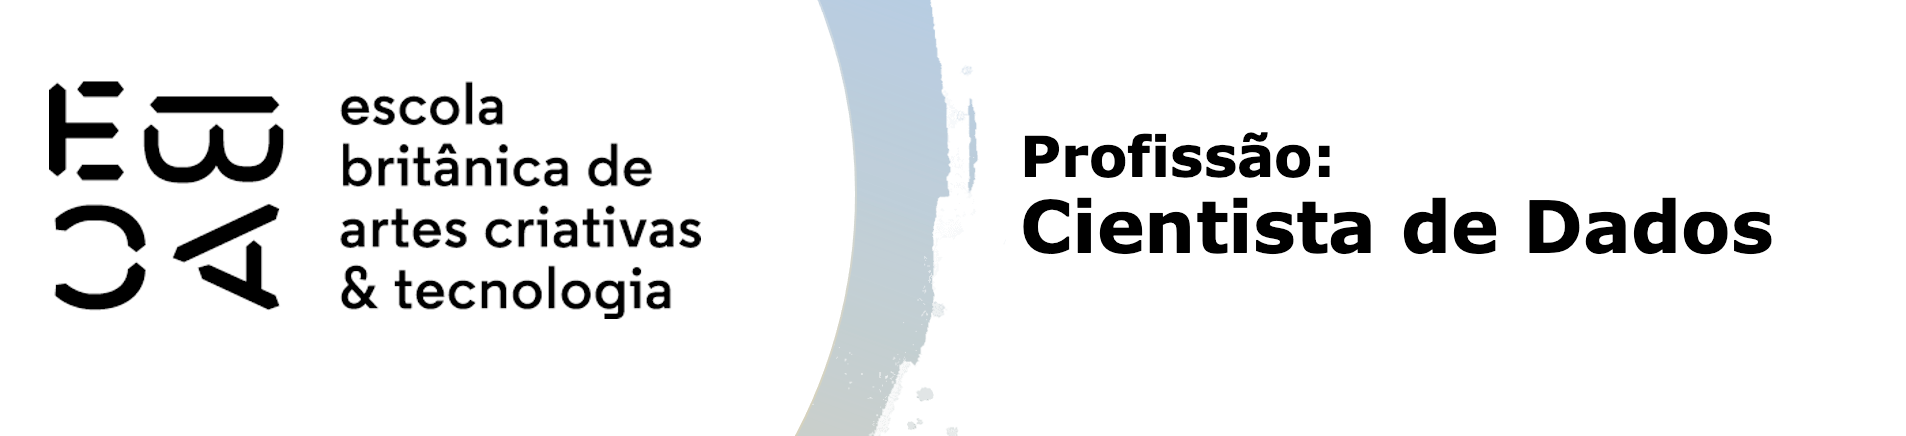

# Análise Longitudinal e Validação OOT

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

In [333]:
#importando pacotes:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

In [334]:
#carregando e exibindo a base:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separaremos os três últimos meses como safras de validação *Out Of Time* (OOT).

Variáveis:<br>
Lembrando que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não será utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não será utilizada como covariável (variável explicativa). As restantes serão utilizadas para prever a inadimplência, incluindo a renda.

In [336]:
# Separando os conjuntos de treinamento e teste com base na OOT:
train = df[df['data_ref'] <= '2015-12-31']  # Até dezembro de 2015
test = df[df['data_ref'] >= '2016-01-01']   # A partir de janeiro de 2016

## Descritiva Básica Univariada Longitudial

Utilizaremos uma função e um laço *for* para a criação dos gráficos que retornam a análise univariada ao longo do tempo. Mas antes disso, iremos explorar a distribuição de amostras por safras do nosso df. 

In [338]:
# Agrupando os dados por mês e contando o número de linhas por mês
df_grouped = train.groupby(pd.Grouper(key='data_ref', freq='ME')).size()

# Alterando o índice para mostrar apenas o nome do mês (ex: 'Jan', 'Feb', ...)
df_grouped.index = df_grouped.index.strftime('%b')

# Exibindo o resultado
df_grouped

data_ref
Jan    50000
Feb    50000
Mar    50000
Apr    50000
May    50000
Jun    50000
Jul    50000
Aug    50000
Sep    50000
Oct    50000
Nov    50000
Dec    50000
dtype: int64

Podemos ver acima que nossas safras são bem equilibradas, com um número comum de amostras para todas. 

A seguir, temos a função para a realização da análise univariada longitudial:

In [340]:
# Função para análise univariada longitudinal
def univariate_analysis(train, variable):
    
    print(f"Análise Longitudinal da Variável: {variable}")
    
    if train[variable].dtype in ['int64', 'float64']:  # Variável quantitativa
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.lineplot(x='data_ref', y=variable, data=train, ax=ax)
        plt.title(f"Comportamento de '{variable}' ao longo do tempo")
        plt.xlabel("Data de Referência")
        plt.ylabel(variable)
        plt.show()
    else:  # Variável qualitativa
        fig, ax = plt.subplots(figsize=(10, 6))
        train.groupby('data_ref')[variable].value_counts().unstack().plot(kind='line', ax=ax)
        plt.title(f"Comportamento de '{variable}' ao longo do tempo")
        plt.xlabel("Data de Referência")
        plt.ylabel("Contagem")
        plt.show()

Análise Longitudinal da Variável: sexo


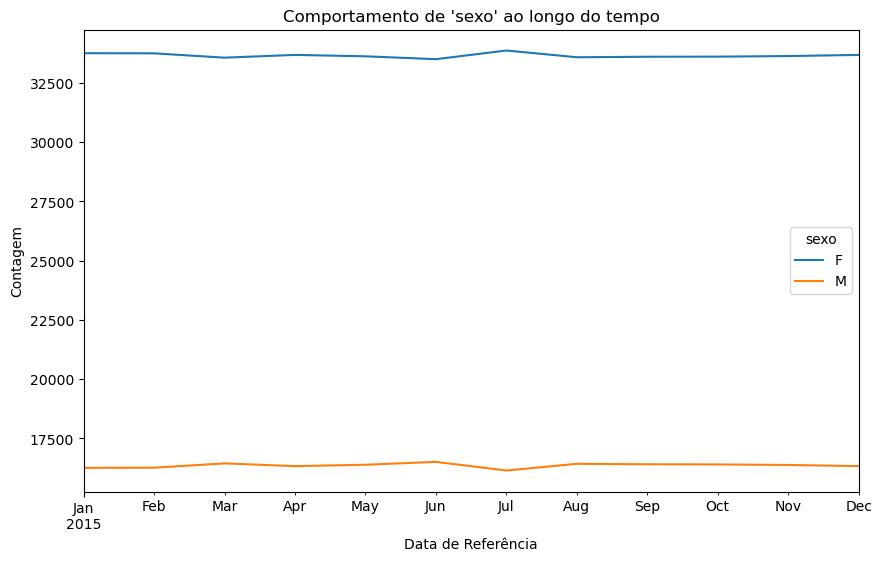

Análise Longitudinal da Variável: posse_de_veiculo


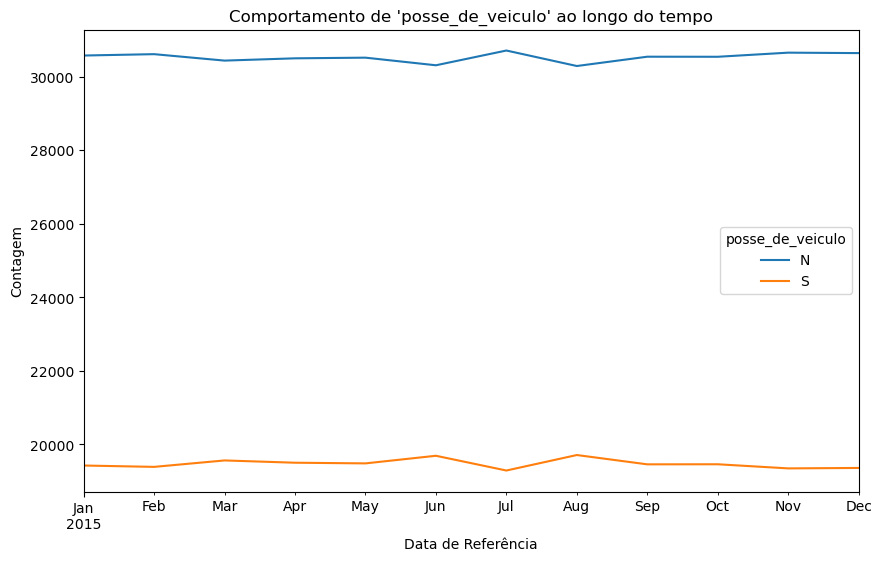

Análise Longitudinal da Variável: posse_de_imovel


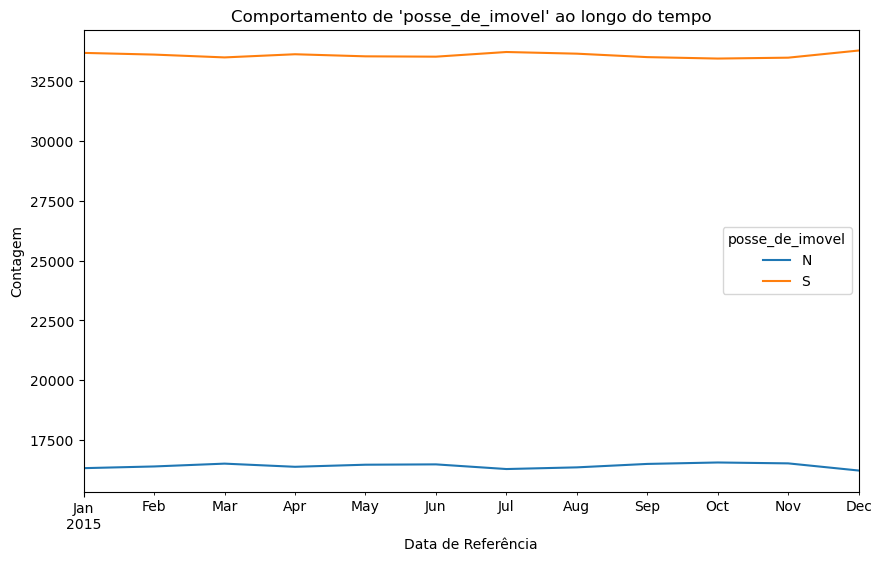

Análise Longitudinal da Variável: qtd_filhos


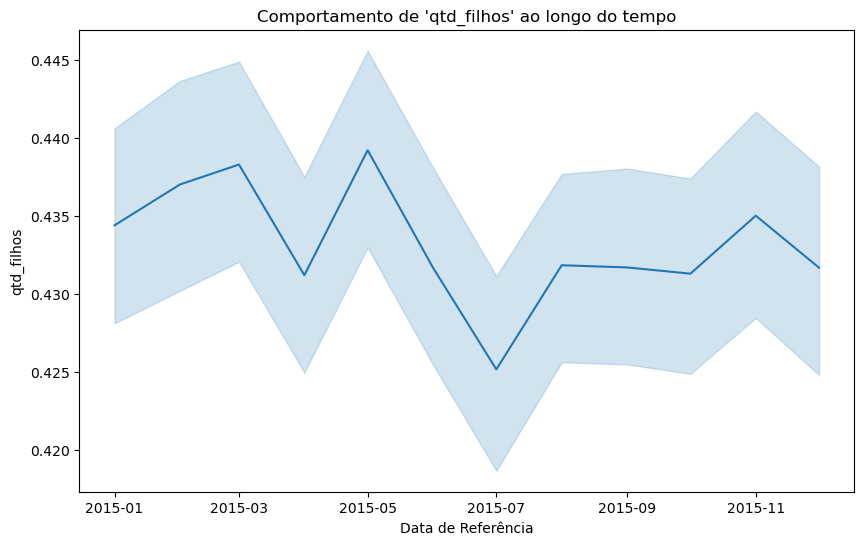

Análise Longitudinal da Variável: tipo_renda


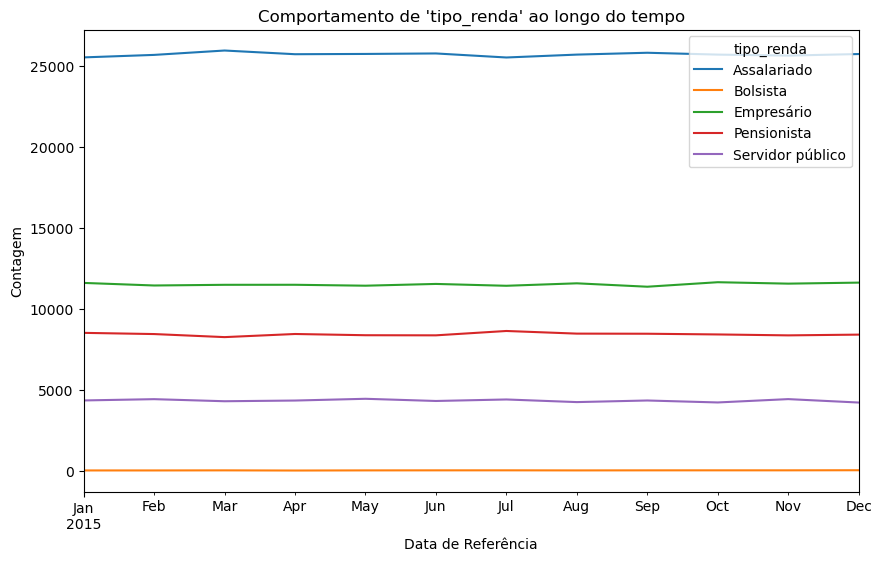

Análise Longitudinal da Variável: educacao


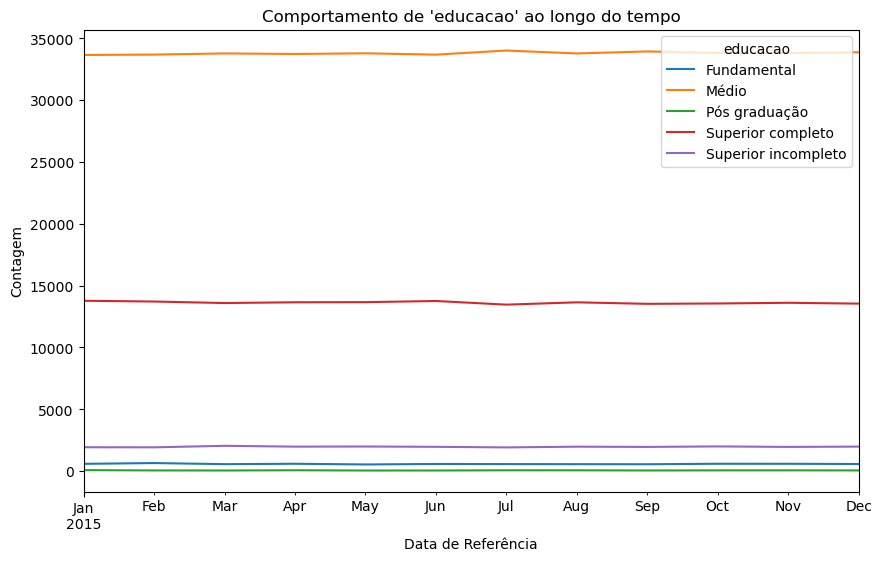

Análise Longitudinal da Variável: estado_civil


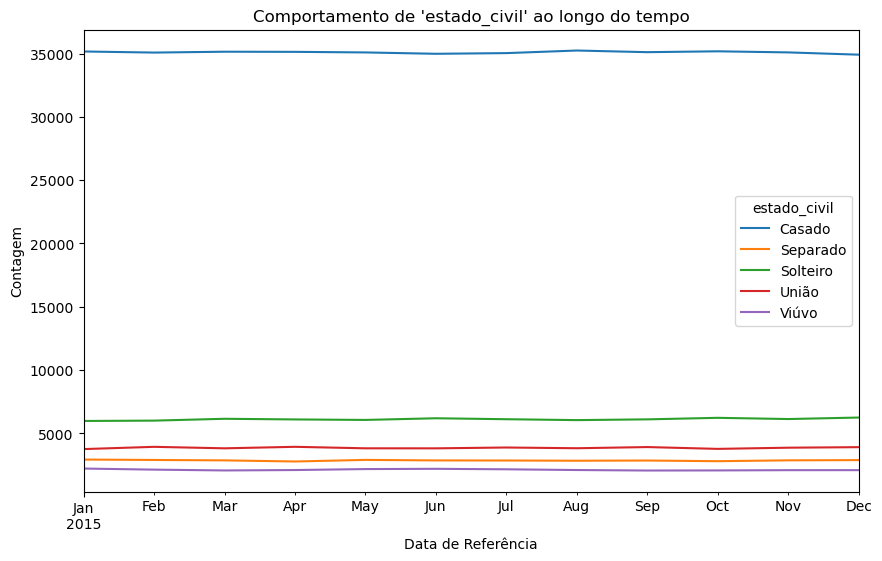

Análise Longitudinal da Variável: tipo_residencia


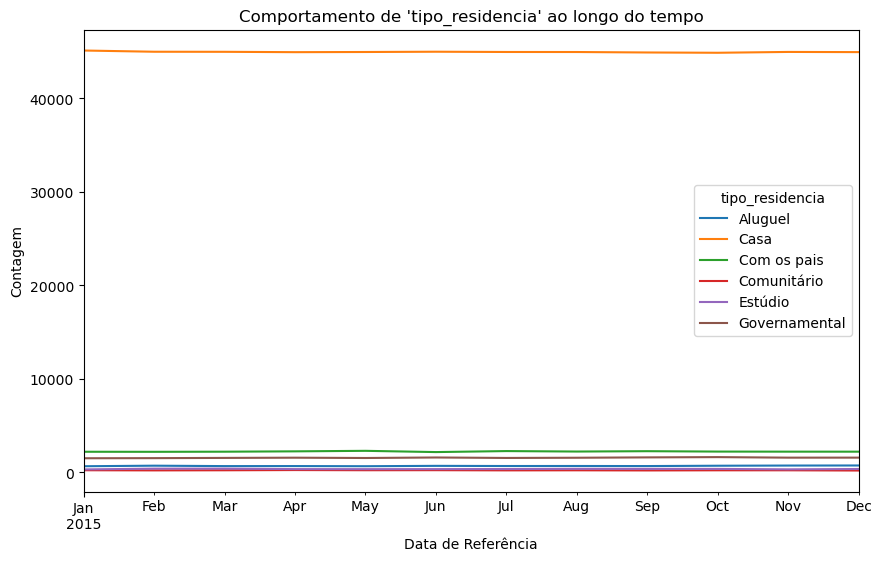

Análise Longitudinal da Variável: idade


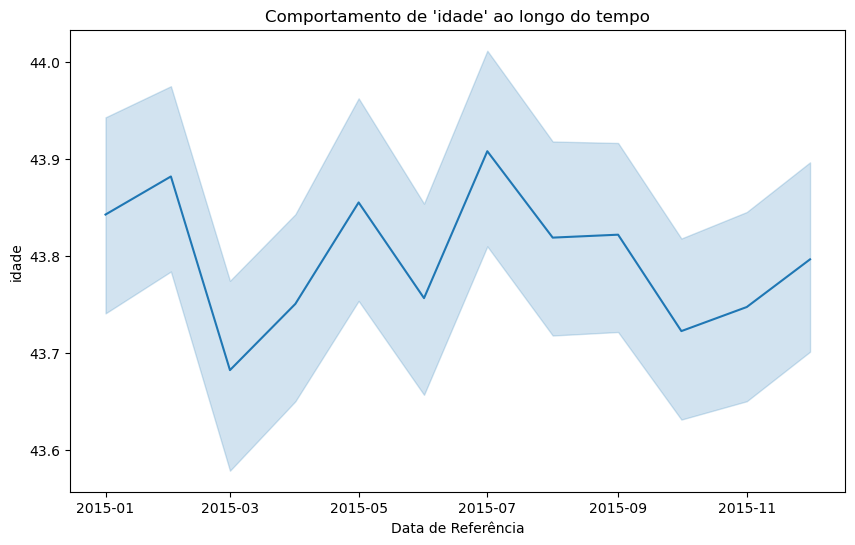

Análise Longitudinal da Variável: tempo_emprego


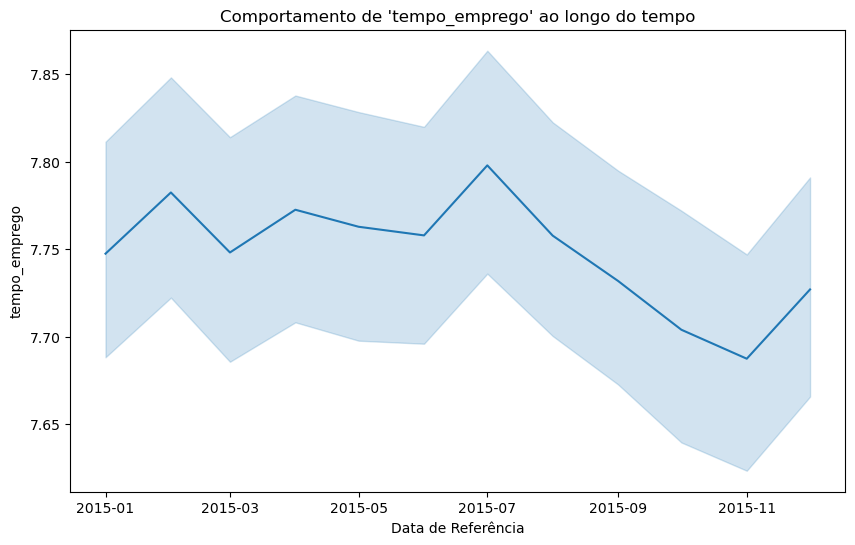

Análise Longitudinal da Variável: qt_pessoas_residencia


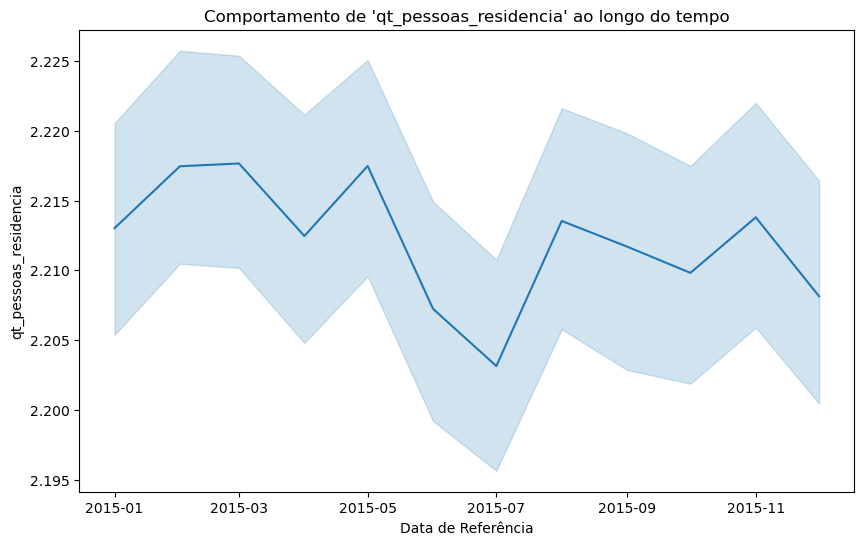

Análise Longitudinal da Variável: renda


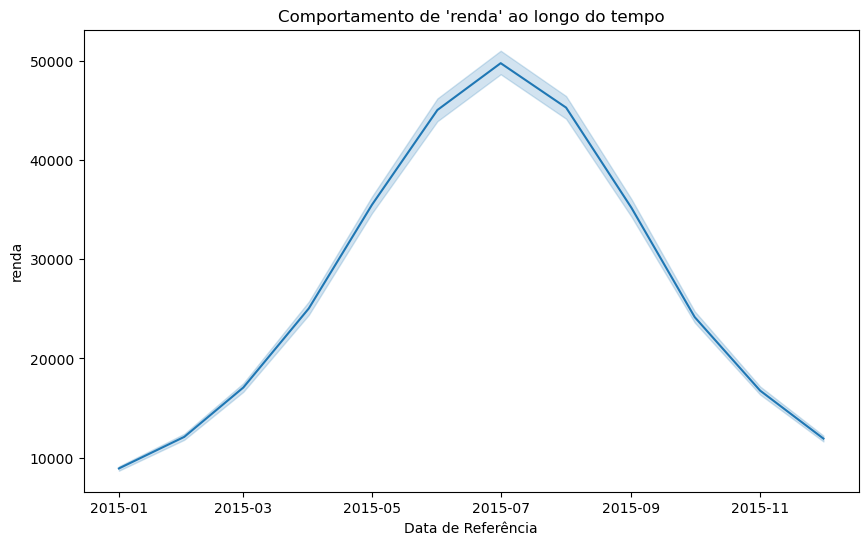

Análise Longitudinal da Variável: mau


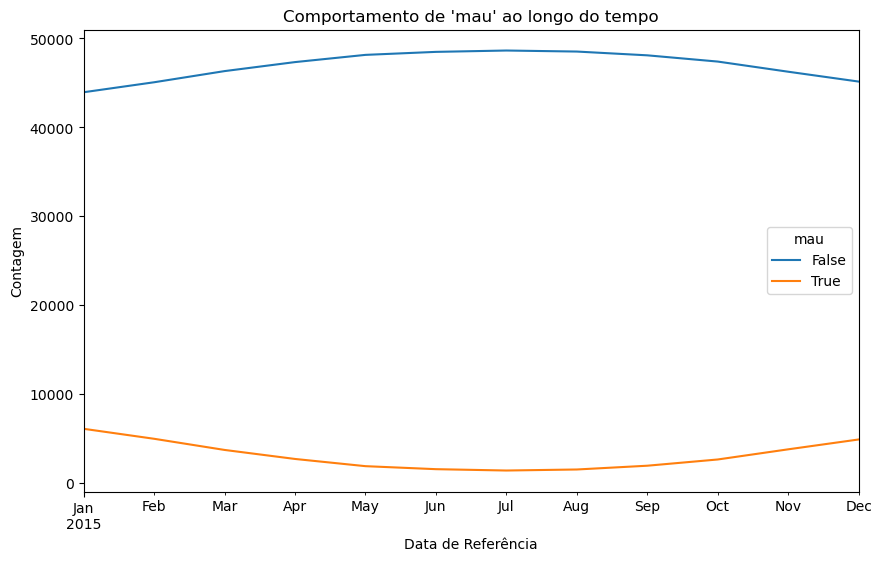

In [341]:
# Removendo as colunas 'data_ref' e 'index' de train.columns e salvando em variaveis:
variaveis = train.drop(columns=['data_ref', 'index']).columns

# Loop para aplicar a análise para todas as variáveis definidas acima:
# Loop para aplicar a análise para todas as variáveis definidas acima:
for variavel in variaveis:
    univariate_analysis(train, variavel)

In [342]:
train.idade.describe()

count    600000.000000
mean         43.798530
std          11.230659
min          22.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          68.000000
Name: idade, dtype: float64

In [343]:
train['idade'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

0.1    29.0
0.2    33.0
0.3    36.0
0.4    40.0
0.5    43.0
0.6    47.0
0.7    51.0
0.8    55.0
0.9    60.0
Name: idade, dtype: float64

Observando os gráficos acima, podemos notar rapidamente algumas coisas (de acordo com as safras verificadas):
- O público feminino é superior ao masculino;
- A maioria dos clientes não possuem veículo;
- A maioria possui imóvel;
- A maioria do público tem entre 0 e 1 filho, visto que temos uma média baixa.
- A maioria dos clientes são assalariados;
- O grau de escolaridade mais frequente é ensino médio;
- O estado civil mais frequente é casado;
- O tipo de residência mais comum é casa;
- 70% nosso público apresenta uma idade acima de 36 anos.
- A média de tempo_emprego do nosso grupo de clientes é bem alta, provavelmente associado à idade que é referente à pessoas um pouco mais velhas;
- Clientes que tiverem o cadastro realizado entre maio e setembro parecem ter as maiores rendas e também as menores taxas de inadimplência. 

## Descritiva bivariada

A seguir, faremos a descritiva bivariada para entender melhor as relações estabelecidas entre as variáveis acima citadas e a variável mau:

In [346]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def bivariate_analysis(train, variable, target='mau'):
    """
    Realiza uma análise bivariada entre uma variável e a variável target (mau).
    
    Parâmetros:
    train (pd.DataFrame): O DataFrame contendo os dados.
    variable (str): A variável a ser analisada.
    target (str): A variável target (padrão é 'mau').
    """
    print(f"Análise Bivariada: {variable} vs {target}")
    
    # Verifica se a variável é quantitativa ou qualitativa
    if train[variable].dtype in ['int64', 'float64']:  # Variável quantitativa
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.boxplot(x=target, y=variable, data=train, ax=ax)
        plt.title(f"Distribuição de '{variable}' por '{target}'")
        plt.xlabel(target)
        plt.ylabel(variable)
        plt.show()
        
        # Exibe estatísticas descritivas agrupadas por 'mau'
        print(train.groupby(target)[variable].describe())
        
    else:  # Variável qualitativa
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.countplot(x=variable, hue=target, data=train, ax=ax)
        plt.title(f"Contagem de '{variable}' por '{target}'")
        plt.xlabel(variable)
        plt.ylabel("Contagem")
        plt.legend(title=target)
        plt.show()
        
        # Exibe tabela de contingência
        contingency_table = pd.crosstab(train[variable], train[target], margins=True, normalize='index')
        print(contingency_table)

Análise Bivariada: sexo vs mau


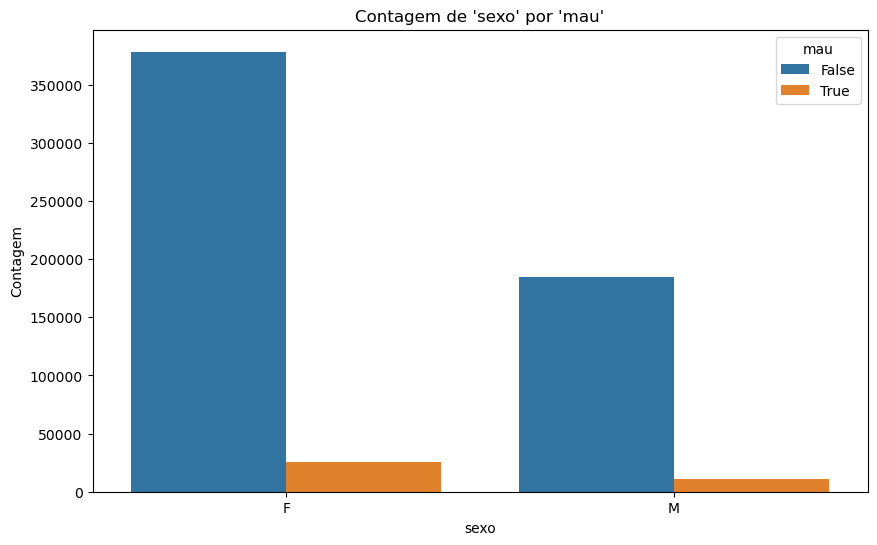

mau      False      True
sexo                    
F     0.936883  0.063117
M     0.943138  0.056862
All   0.938928  0.061072
Análise Bivariada: posse_de_veiculo vs mau


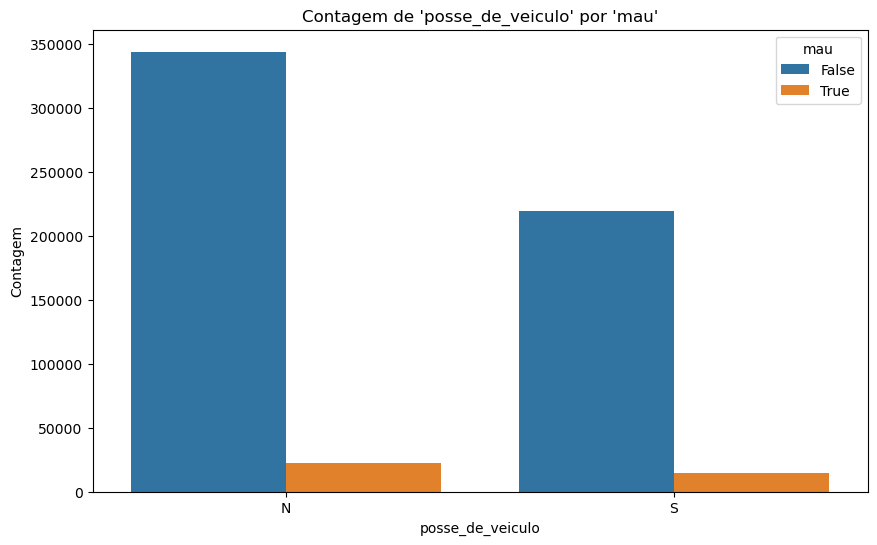

mau                  False      True
posse_de_veiculo                    
N                 0.938533  0.061467
S                 0.939548  0.060452
All               0.938928  0.061072
Análise Bivariada: posse_de_imovel vs mau


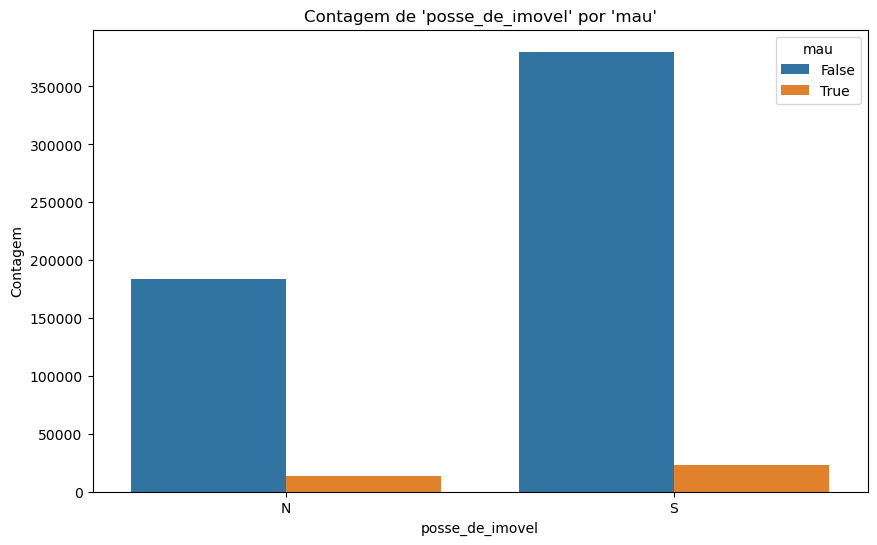

mau                 False      True
posse_de_imovel                    
N                0.930737  0.069263
S                0.942931  0.057069
All              0.938928  0.061072
Análise Bivariada: qtd_filhos vs mau


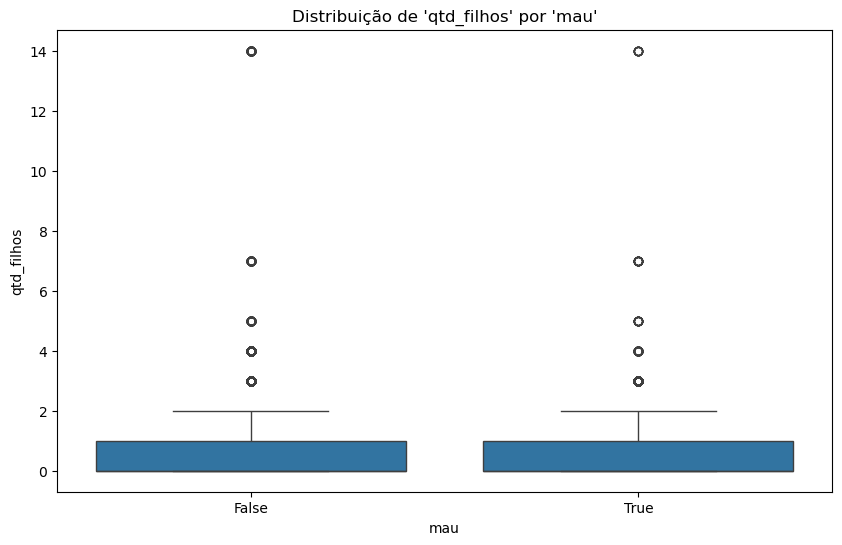

          count      mean       std  min  25%  50%  75%   max
mau                                                          
False  563357.0  0.431925  0.738337  0.0  0.0  0.0  1.0  14.0
True    36643.0  0.452965  0.762783  0.0  0.0  0.0  1.0  14.0
Análise Bivariada: tipo_renda vs mau


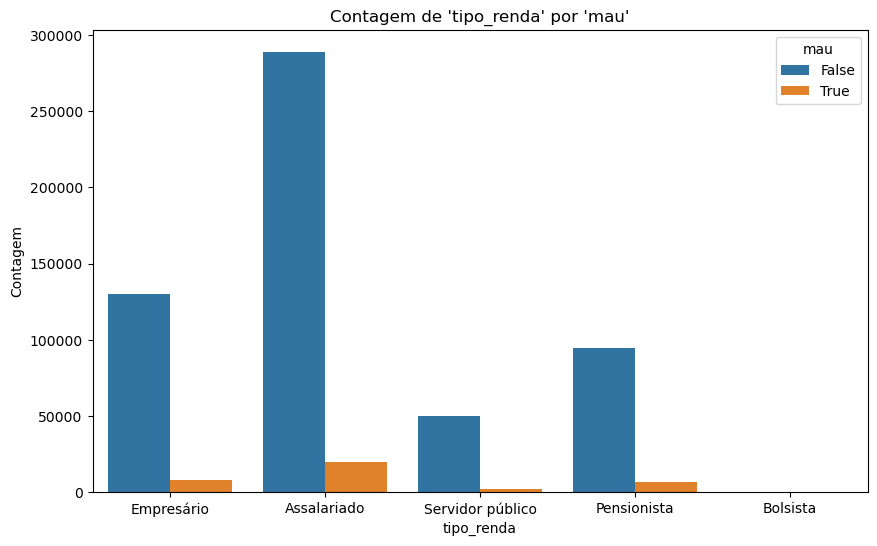

mau                  False      True
tipo_renda                          
Assalariado       0.936475  0.063525
Bolsista          0.958763  0.041237
Empresário        0.940597  0.059403
Pensionista       0.935724  0.064276
Servidor público  0.955176  0.044824
All               0.938928  0.061072
Análise Bivariada: educacao vs mau


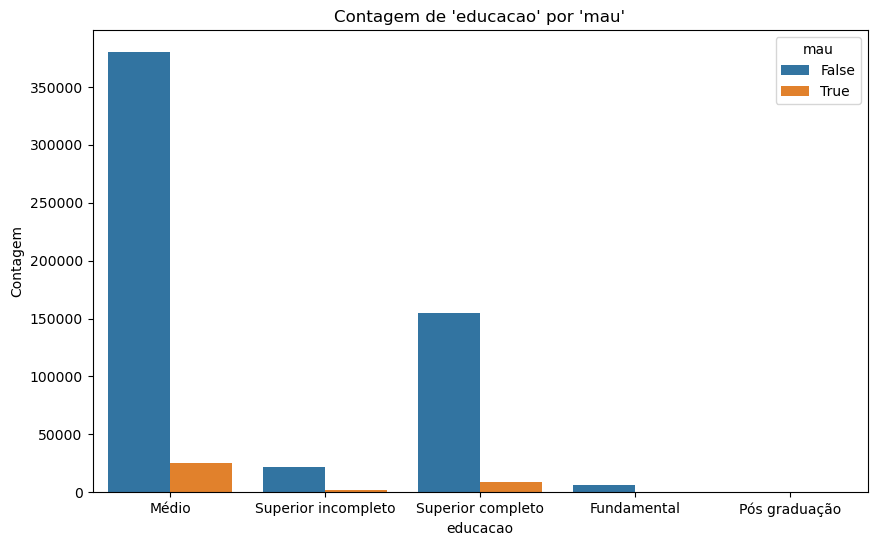

mau                     False      True
educacao                               
Fundamental          0.930300  0.069700
Médio                0.937082  0.062918
Pós graduação        0.933948  0.066052
Superior completo    0.944408  0.055592
Superior incompleto  0.935354  0.064646
All                  0.938928  0.061072
Análise Bivariada: estado_civil vs mau


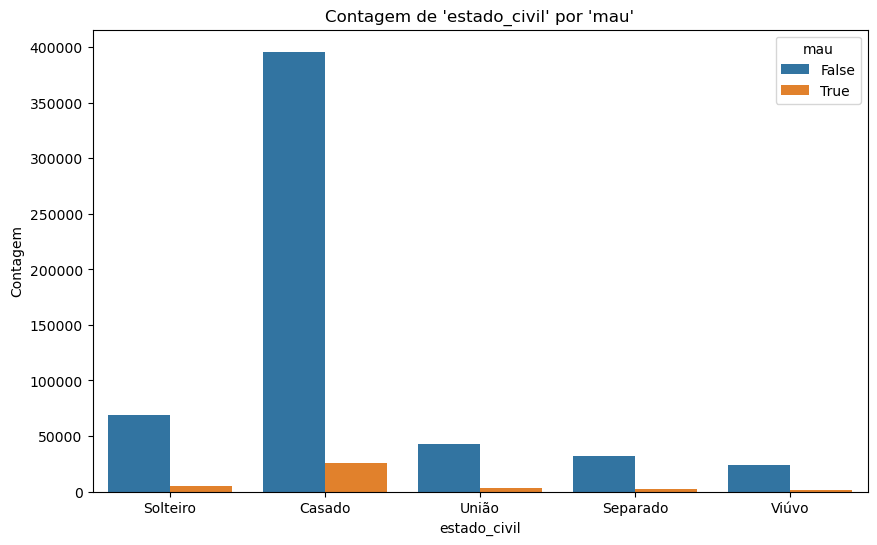

mau              False      True
estado_civil                    
Casado        0.940000  0.060000
Separado      0.935825  0.064175
Solteiro      0.936685  0.063315
União         0.933634  0.066366
Viúvo         0.941423  0.058577
All           0.938928  0.061072
Análise Bivariada: tipo_residencia vs mau


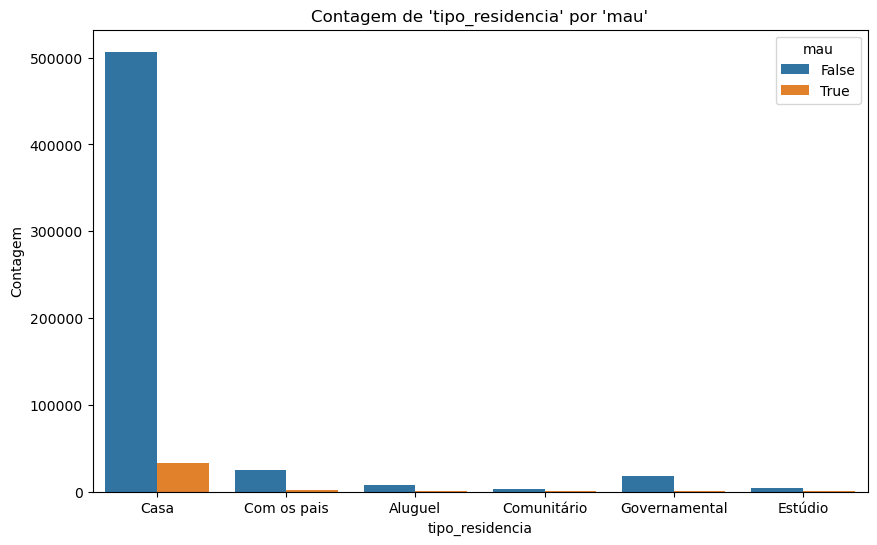

mau                 False      True
tipo_residencia                    
Aluguel          0.927863  0.072137
Casa             0.939835  0.060165
Com os pais      0.925290  0.074710
Comunitário      0.929765  0.070235
Estúdio          0.947626  0.052374
Governamental    0.936453  0.063547
All              0.938928  0.061072
Análise Bivariada: idade vs mau


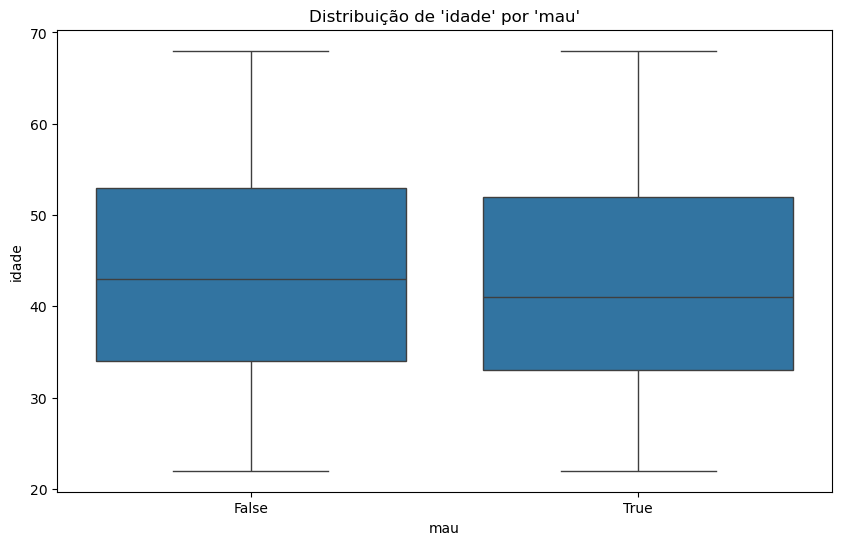

          count       mean        std   min   25%   50%   75%   max
mau                                                                
False  563357.0  43.871059  11.202135  22.0  34.0  43.0  53.0  68.0
True    36643.0  42.683459  11.603637  22.0  33.0  41.0  52.0  68.0
Análise Bivariada: tempo_emprego vs mau


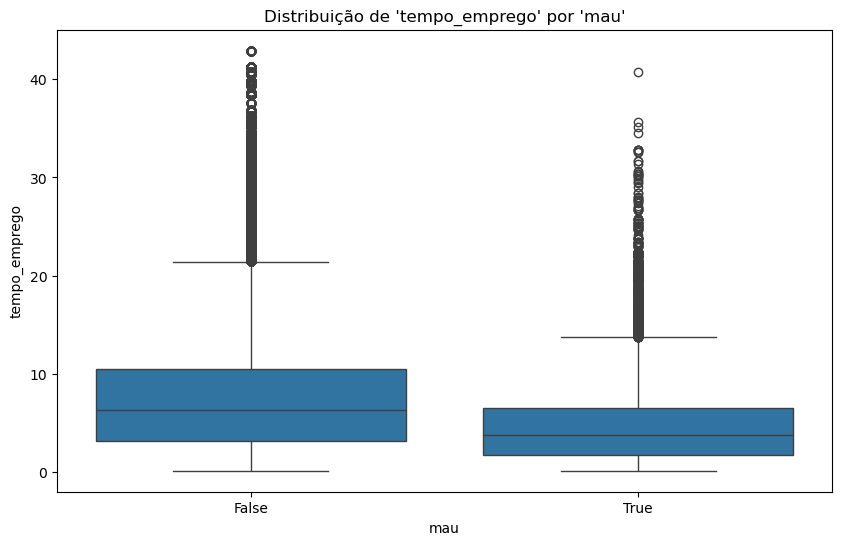

          count      mean       std       min       25%       50%        75%  \
mau                                                                            
False  468960.0  7.948183  6.780904  0.117808  3.183562  6.263014  10.479452   
True    30165.0  4.635732  3.885166  0.117808  1.698630  3.802740   6.504110   

             max  
mau               
False  42.906849  
True   40.786301  
Análise Bivariada: qt_pessoas_residencia vs mau


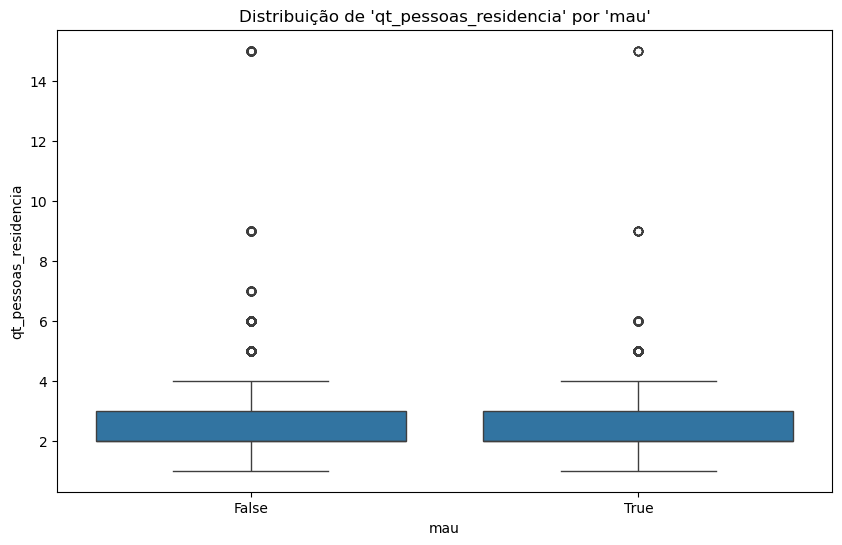

          count      mean       std  min  25%  50%  75%   max
mau                                                          
False  563357.0  2.211244  0.902106  1.0  2.0  2.0  3.0  15.0
True    36643.0  2.225609  0.928682  1.0  2.0  2.0  3.0  15.0
Análise Bivariada: renda vs mau


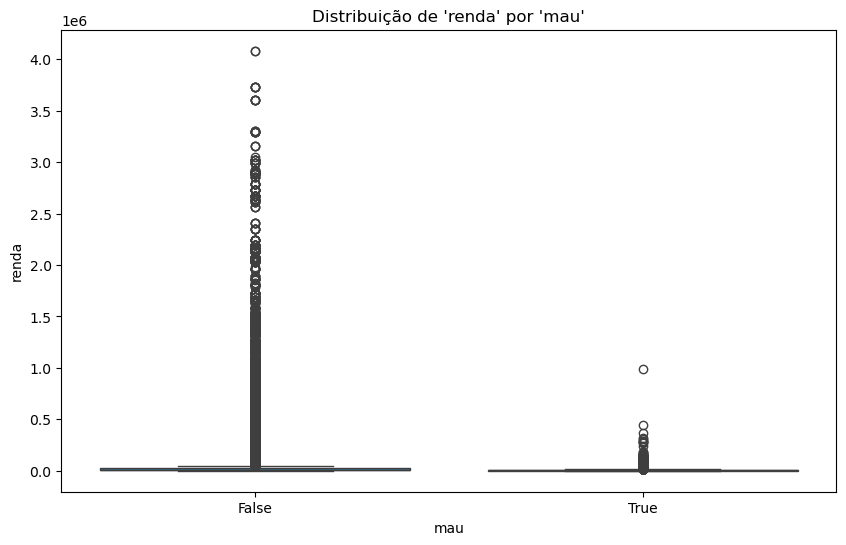

          count          mean           std     min      25%       50%  \
mau                                                                      
False  563357.0  28588.375290  89957.956947  168.02  5060.31  10526.84   
True    36643.0   6228.897766  11452.920855  161.86  1844.38   3523.88   

             75%         max  
mau                           
False  22744.950  4083986.22  
True    7004.815   989799.47  


In [347]:
# Removendo as colunas 'data_ref' e 'index' de train.columns e salvando em variaveis:
variaveis = train.drop(columns=['data_ref', 'index', 'mau']).columns

# Loop para aplicar a análise bivariada para todas as variáveis definidas acima:
for variavel in variaveis:
    bivariate_analysis(train, variavel)

**Conclusões:** 

Aqui conseguimos novamente reparar as informações obtidas com a análise univariada. O foco aqui será observar se temos algumas classes que podemos juntar ou identificar quando as distribuições entre as categorias analisadas estão muito discrepantes indicando forte poder preditivo. 

- **Bolsista** é uma categoria muito pequena em relação às demais contidas em *Tipo de Renda*, por isso, vamos **juntá-la com servidor público**, que é a classe com a distribuição próxima;
- Para educação, temos todas as classes com distribuições parecidas, sendo o superior completo com menor porcentagem de inadimplência. Se fossemos agrupar por proximidade de proporção, teria que ser: **Superior Completo, Médio/Superior Incompleto, Pós/Fundamental;**
- Para a variável Tempo de Emprego, podemos perceber que **inadimplentes tem uma média de emprego bem menor que adimplentes.**
- A variável Renda também parece ser bem discriminatória, uma vez que **a média de renda dos inadimplentes é entre 4 e 5 vezes menor que a média dos adimplentes.**

*obs: Na próxima etapa, iremos decidir se vamos utilizar os agrupamentos aqui sugeridos, uma vez que iremos verificar o IV das variáveis e optar pelas com maior valor de informação.*

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [350]:
train.describe()

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,600000,600000.000000,600000.000000,600000.000000,499125.000000,600000.000000,6.000000e+05
mean,2015-06-16 12:00:00,8322.563235,0.433210,43.798530,7.747992,2.212122,2.722284e+04
min,2015-01-01 00:00:00,0.000000,0.000000,22.000000,0.117808,1.000000,1.618600e+02
25%,2015-03-24 06:00:00,4147.000000,0.000000,34.000000,3.049315,2.000000,4.670600e+03
50%,2015-06-16 00:00:00,8330.000000,0.000000,43.000000,6.046575,2.000000,9.887580e+03
75%,2015-09-08 12:00:00,12494.000000,1.000000,53.000000,10.180822,3.000000,2.162887e+04
max,2015-12-01 00:00:00,16649.000000,14.000000,68.000000,42.906849,15.000000,4.083986e+06
std,NaN,4810.120431,0.739869,11.230659,6.688576,0.903757,8.737788e+04


In [351]:
train.duplicated().sum()

381646

Observando a análise descritiva acima, principalmente se atentando aos quartis, podemos ver que algumas variáveis tem um salto muito alto do terceiro para o quarto quartil. 

Nosso banco de dados tem 600 mil observações, porém possui várias entradas duplicadas. Nesse momento, trabaharemos apenas com a remoção de alguns outliers e deixaremos os dados duplicados pois representam uma parcela muito grande do nosso df. 

Vamos estabelecendo alguns critérios aqui e decidindo quais dados serão removidos. Buscaremos por valores máximos, por categoria, um pouco mais próximos do terceiro quartil mas que não represente a exclusão de muitas observações. 

In [353]:
train[train['qtd_filhos'] > 5]

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
844,2015-01-01,13556,F,N,N,7,Assalariado,Médio,Casado,Casa,37,4.517808,9.0,1127.66,True
3186,2015-01-01,13557,F,N,N,7,Assalariado,Médio,Casado,Casa,37,4.517808,9.0,1047.58,False
3255,2015-01-01,13557,F,N,N,7,Assalariado,Médio,Casado,Casa,37,4.517808,9.0,1047.58,False
3584,2015-01-01,6791,M,S,S,14,Assalariado,Médio,Separado,Casa,48,4.627397,15.0,1022.25,True
6776,2015-01-01,6790,M,S,S,14,Assalariado,Médio,Separado,Casa,48,4.627397,15.0,6038.10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570848,2015-12-01,6790,M,S,S,14,Assalariado,Médio,Separado,Casa,48,4.627397,15.0,8113.17,False
571132,2015-12-01,13556,F,N,N,7,Assalariado,Médio,Casado,Casa,37,4.517808,9.0,1515.19,False
587371,2015-12-01,6790,M,S,S,14,Assalariado,Médio,Separado,Casa,48,4.627397,15.0,8113.17,False
592287,2015-12-01,13557,F,N,N,7,Assalariado,Médio,Casado,Casa,37,4.517808,9.0,1407.59,False


In [354]:
#7: casal + 5 filhos
train[train['qt_pessoas_residencia'] > 7]

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
844,2015-01-01,13556,F,N,N,7,Assalariado,Médio,Casado,Casa,37,4.517808,9.0,1127.66,True
3186,2015-01-01,13557,F,N,N,7,Assalariado,Médio,Casado,Casa,37,4.517808,9.0,1047.58,False
3255,2015-01-01,13557,F,N,N,7,Assalariado,Médio,Casado,Casa,37,4.517808,9.0,1047.58,False
3584,2015-01-01,6791,M,S,S,14,Assalariado,Médio,Separado,Casa,48,4.627397,15.0,1022.25,True
6776,2015-01-01,6790,M,S,S,14,Assalariado,Médio,Separado,Casa,48,4.627397,15.0,6038.10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570848,2015-12-01,6790,M,S,S,14,Assalariado,Médio,Separado,Casa,48,4.627397,15.0,8113.17,False
571132,2015-12-01,13556,F,N,N,7,Assalariado,Médio,Casado,Casa,37,4.517808,9.0,1515.19,False
587371,2015-12-01,6790,M,S,S,14,Assalariado,Médio,Separado,Casa,48,4.627397,15.0,8113.17,False
592287,2015-12-01,13557,F,N,N,7,Assalariado,Médio,Casado,Casa,37,4.517808,9.0,1407.59,False


Testando diversos números acima, aparentemente, 5 para filhos e 7 para quantidade de pessoas na residência parecem encaixar bem, parecendo inclusive se tratar das mesmas pessoas. 

Vamos observar agora a variável com maior desvio padrão e provavelmente a que tomaremos a decisão com base na quantidade de observações que serão removidas, tomando cuidado para não ser um número muito grande.

In [356]:
train[train['renda'] > 1400000].shape

(416, 15)

Novamente, após testar alguns valores, optei por algo que somado às observações de cima, não representasse mais que 0,1% do df. Agora, iremos criar um novo df com esses filtros, aonde os números acima estipulados serão o limite de cada uma das 3 variáveis vistas. 

In [358]:
# Remover as linhas onde 'qtd_filhos' é maior que 5, 'qt_pessoas_residencia' maior que 7 e 'renda' maior que 2.000.000
train = train[train['qtd_filhos'] <= 5]
train = train[train['qt_pessoas_residencia'] <= 7]
train = train[train['renda'] <= 1400000]

# Verificar as dimensões do DataFrame após as remoções
train.shape


(599431, 15)

In [359]:
((600000-599431)/600000)*100

0.09483333333333334

In [360]:
train.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [361]:
# Filtrando valores unicos de tipo de renda para emprego missing:
train.loc[train['tempo_emprego'].isna(), 'tipo_renda'].unique()

array(['Pensionista'], dtype=object)

Por hora, deixaremos não preenchidos os valores para pensionistas e depois, na hora de analisar o WOE vemos aonde se encaixa melhor, se é no 0, visto que esses pensionistas não estão mais trabalhando, ou se é no valor máximo, visto que eles já tiveram um tempo_emprego alto a ponto de estarem aposentados.

Vamos começar a organizar nosso metadados, que receberá: nº de missings, valores únicos, papel e IV. Para a criação do metadados vamos excluir as colunas que não possuem poder preditivo:

In [363]:
#excluindo as colunas data_ref e index:
train = train.drop(['data_ref', 'index'], axis=1)

Feito isso, agora vamos começar a montar nosso metadados, que receberá primeiramente o tipo da variável, o nº de missings e os valores únicos:

In [365]:
metadados = pd.DataFrame(train.dtypes, columns=['dtype'])
metadados['nmissing'] = train.isna().sum()
metadados['valores_unicos'] = train.nunique()

metadados

,dtype,nmissing,valores_unicos
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,6
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6
idade,int64,0,47
tempo_emprego,float64,100875,3004


Como pudemos ver, temos mau como bool, vamos transformá-la em int, ou seja, 0 e 1:

In [367]:
# Transformar a variável resposta em inteiro
train['mau'] = train.mau.astype('int64')

A seguir vamos definir o papel de cada variável, sendo mau a única variável resposta.

In [369]:
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,6.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel
idade,int64,0.0,47.0,covariavel
tempo_emprego,float64,100875.0,3004.0,covariavel


Agora, o único passo faltante no nosso metadados é o cálculo do IV (Information Value), vamos criar a função que realiza o cálculo e em seguida, dando um loop, utilizá-la para todas as variáveis:

In [371]:
#função cálculo IV
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [372]:
#loop:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6): #para mais que 6 valores unicos, usamos pd.qcut
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.002185
posse_de_veiculo,object,0.0,2.0,covariavel,0.000108
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
qtd_filhos,int64,0.0,6.0,covariavel,0.001631
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
estado_civil,object,0.0,5.0,covariavel,0.001126
tipo_residencia,object,0.0,6.0,covariavel,0.003045
idade,int64,0.0,47.0,covariavel,0.017968
tempo_emprego,float64,100875.0,3004.0,covariavel,0.351920


*Geralmente, utiliza-se no modelo, as variáveis com IV maior que 2%*, seriam elas:

- **Tempo emprego**: precisa ser tratada visto que deixamos 0s para traz.
- **Renda**.

*Porém, como temos apenas duas covariáveis com IV maior que 2%, e o intuíto aqui é praticar algumas coisas, vamos verificar se há classes de variáveis que poderiamos unir, para isso, foram escolhidas educação e tipo de renda.*

*Faremos isso apenas para efeito de testes, uma vez que não possuímos zeros estruturais, caso possuí-se, não teriamos o valor de IV para todas as covariaveis, uma vez que não há divisão por 0.*

In [374]:
#função para calcular o woe das classes de uma variável:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])
    plt.subplots_adjust(hspace=0.5)
    
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    plt.subplots_adjust(hspace=0.5)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    plt.subplots_adjust(hspace=0.5)
    
    ax[1] = biv.cont.plot.bar()
    return biv

Começando a análise do WOE para as classes da variável tipo_renda:

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288468,19575,0.063546,Assalariado,308043,0.000440,0.064408,0.062685,-2.690331,-2.675945,-2.704899,0.041931,0.056317,0.027363
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.414043,0.052504,-1.250354
Empresário,129903,8206,0.059417,Empresário,138109,0.000636,0.060664,0.058170,-2.761922,-2.739829,-2.784454,-0.029660,-0.007567,-0.052192
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054121,0.078982,0.028710
Servidor público,49531,2330,0.044928,Servidor público,51861,0.000910,0.046711,0.043145,-3.056730,-3.015947,-3.099087,-0.324468,-0.283685,-0.366825


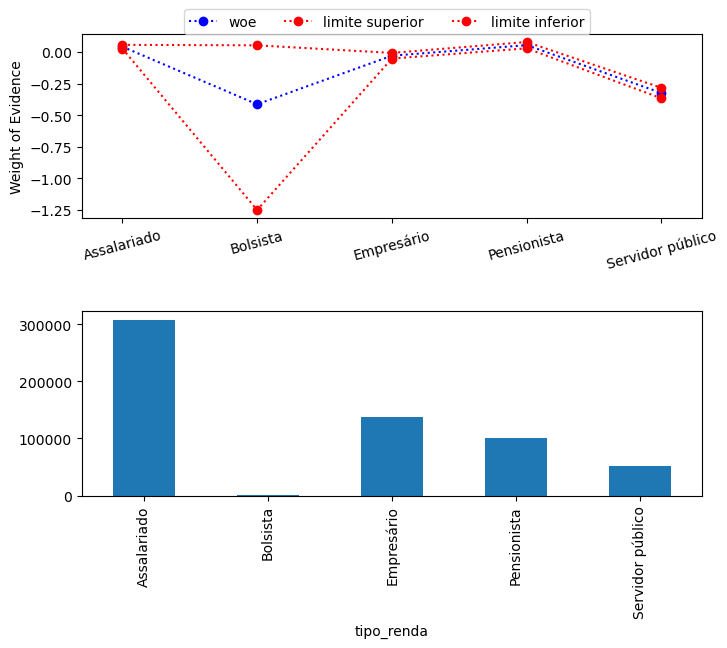

In [376]:
biv_discreta('tipo_renda', train)

*Bolsista* é uma categoria muito pequena em relação às demais contidas em *Tipo de Renda*, por isso, vamos **juntá-la com servidor público**, que é a classe com a distribuição próxima e ver o que acontece:

C:\Users\charl\AppData\Local\Temp\ipykernel_10832\743041028.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_copy['tipo_renda'].replace({'Servidor público': 'Servidor público/Bolsista',


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288468,19575,0.063546,Assalariado,308043,0.000440,0.064408,0.062685,-2.690331,-2.675945,-2.704899,0.041931,0.056317,0.027363
Empresário,129903,8206,0.059417,Empresário,138109,0.000636,0.060664,0.058170,-2.761922,-2.739829,-2.784454,-0.029660,-0.007567,-0.052192
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054121,0.078982,0.028710
Servidor público/Bolsista,49810,2342,0.044907,Servidor público/Bolsista,52152,0.000907,0.046685,0.043130,-3.057211,-3.016530,-3.099456,-0.324948,-0.284268,-0.367193


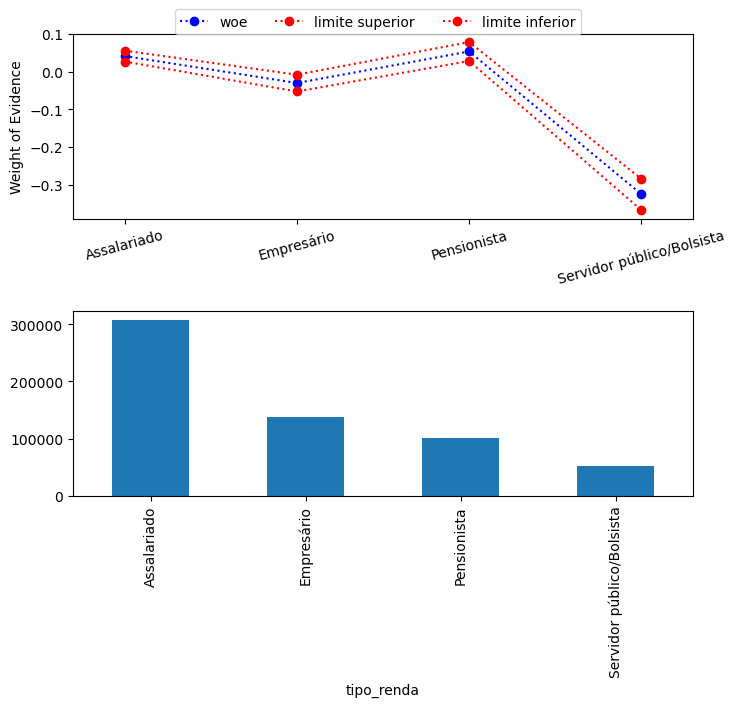

In [378]:
# Cria uma cópia do DataFrame
train_copy = train.copy()

# Substitui os valores na cópia
train_copy['tipo_renda'].replace({'Servidor público': 'Servidor público/Bolsista', 
                                   'Bolsista': 'Servidor público/Bolsista'}, inplace=True)

# Chama a função biv_discreta usando a cópia do DataFrame
biv_discreta('tipo_renda', train_copy)

Com essa união percebemos que o peso da evidencia para ambos acabou caindo, logo, não foi uma boa escolha essa junção, manteria como estava anteriormente. A seguir, observaremos como se comporta educação:

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6420,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.140956,0.230132,0.044362
Médio,379539,25490,0.062934,Médio,405029,0.000382,0.063682,0.062186,-2.700671,-2.688059,-2.713424,0.031591,0.044203,0.018838
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083287,0.358136,-0.278605
Superior completo,154205,9086,0.055643,Superior completo,163291,0.000567,0.056755,0.054531,-2.831548,-2.810585,-2.852909,-0.099286,-0.078323,-0.120647
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060267,0.111061,0.007121


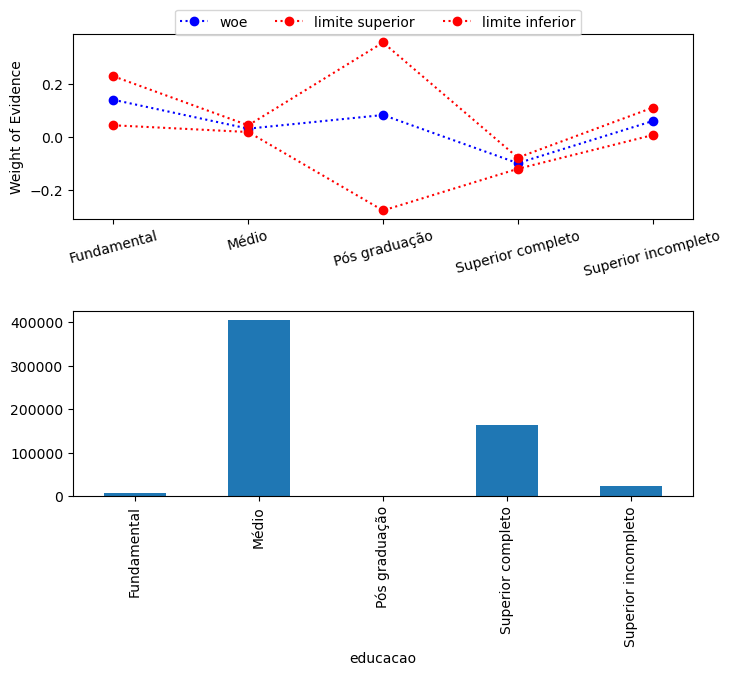

In [380]:
biv_discreta('educacao', train)

Para educação, se lembrarmos da análise bivariada, temos todas as classes com distribuições parecidas, sendo o superior completo com menor porcentagem de inadimplência. 

Se fossemos agrupar por proximidade de proporção, teria que ser: Superior Completo, Médio/Superior Incompleto, Pós/Fundamental. 

Faremos o teste para ver o que ocorre com o WOE:

In [382]:
train_copy['educacao'] = train_copy['educacao'].replace({
    'Médio': 'Médio/Superior incompleto',
    'Superior incompleto': 'Médio/Superior incompleto',
    'Fundamental': 'Fundamental/Pós',
    'Pós graduação': 'Fundamental/Pós',
    'Superior completo': 'Superior completo'})


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental/Pós,7028,524,0.069386,Fundamental/Pós,7552,0.002924,0.075118,0.063654,-2.596166,-2.510612,-2.688530,0.136096,0.221650,0.043732
Médio/Superior incompleto,401575,27013,0.063028,Médio/Superior incompleto,428588,0.000371,0.063755,0.062300,-2.699076,-2.686822,-2.711463,0.033186,0.045440,0.020799
Superior completo,154205,9086,0.055643,Superior completo,163291,0.000567,0.056755,0.054531,-2.831548,-2.810585,-2.852909,-0.099286,-0.078323,-0.120647


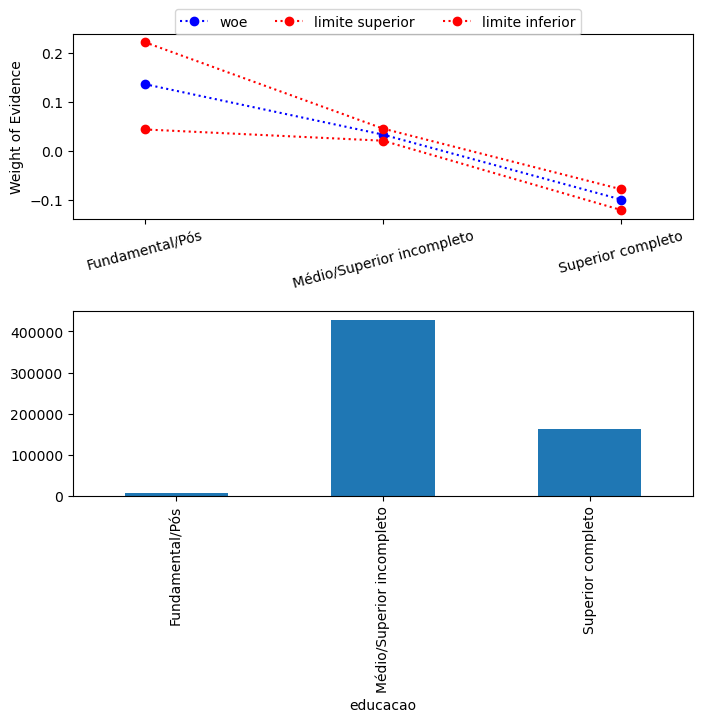

In [383]:
biv_discreta('educacao', train_copy)

Aparentemente, não houveram grandes mudanças aqui. 

A seguir, verificaremos o WOE das variáveis com IV acima de 2%, que serão as mais prováveis de utilizarmos na posterior construção do modelo:

In [385]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

Vamos visualizar tempo_emprego:

C:\Users\charl\AppData\Local\Temp\ipykernel_10832\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


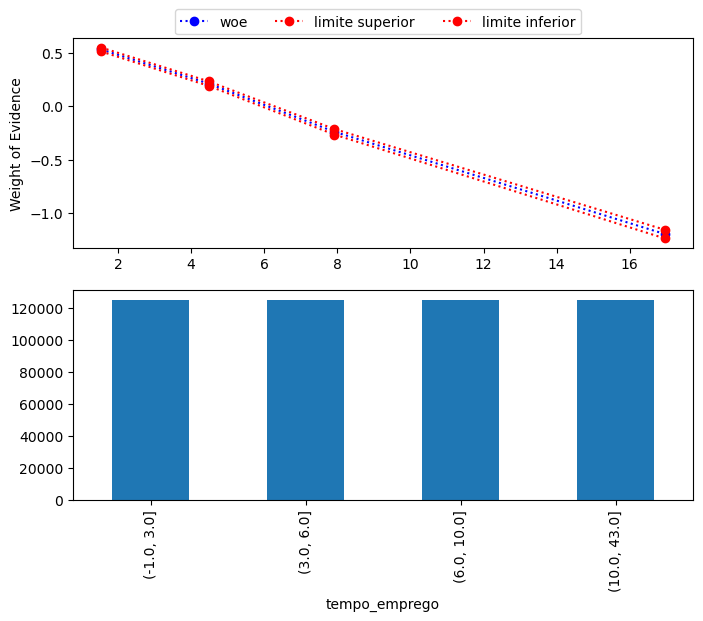

In [387]:
biv_continua('tempo_emprego', 4, train)

Ao testar alguns valores para o qcut (cortes), quanto mais categorias eu crio, mais meu WOE cai. 

Lembrando que ainda temos valores nulos para tempo de emprego, portanto, faremos 2 testes, primeiro completaremos os nulos (Pensionistas) com 0 e posteriormente com o valor máximo 43. E veremos o que ocorre com o WOE:

C:\Users\charl\AppData\Local\Temp\ipykernel_10832\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


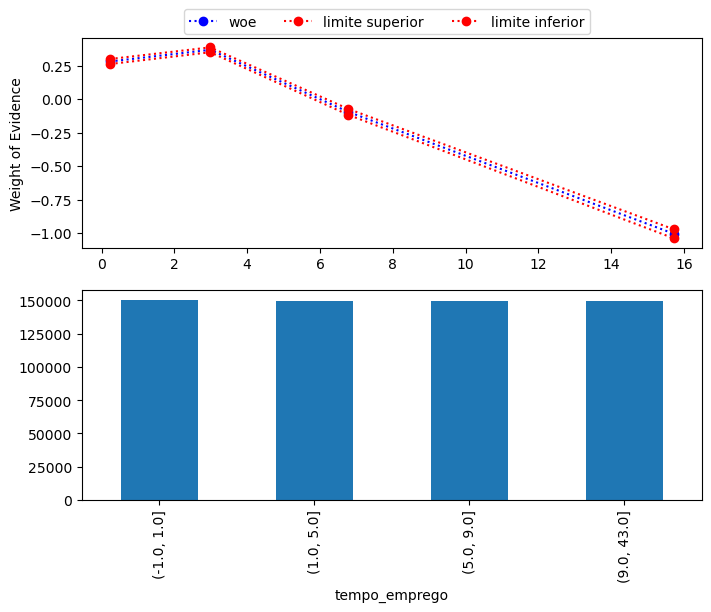

In [389]:
train_copy.loc[train_copy['tipo_renda'] == 'Pensionista', 'tempo_emprego'] = 0
biv_continua('tempo_emprego', 4, train_copy)

Ao completar com 0 temos uma diminuição do WOE, vamos agora tentar completar com 40 que é um valor bem alto.

C:\Users\charl\AppData\Local\Temp\ipykernel_10832\2406241395.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_copy_1['tempo_emprego'].fillna(40, inplace=True)
C:\Users\charl\AppData\Local\Temp\ipykernel_10832\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


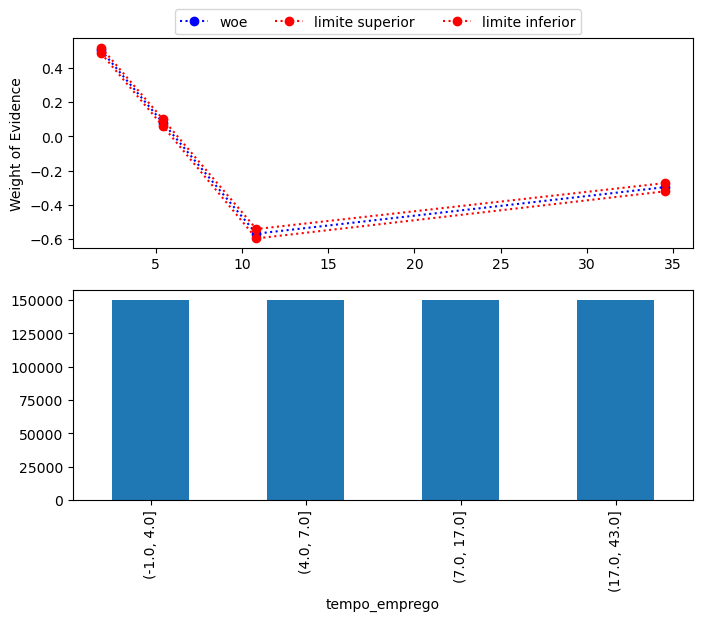

In [391]:
train_copy_1=train.copy()
train_copy_1['tempo_emprego'].fillna(40, inplace=True)
biv_continua('tempo_emprego', 4, train_copy_1)

Aparentemente, ao utilizar 40, temos uma melhora no WOE, por isso, passaremos o 40 para os nulos no df original que seria o train e não o train_copy_1 que usamos apenas para investigar. 

In [393]:
# Preenche valores nulos de 'tempo_emprego' com 40 para todas as linhas
train['tempo_emprego'] = train['tempo_emprego'].fillna(40)
train['tempo_emprego'].isnull().sum()

0

In [394]:
# Verificar a quantidade de valores únicos na coluna 'tempo_emprego'
valores_unicos_tempo_emprego = df['tempo_emprego'].nunique()

# Calcular o IV
if valores_unicos_tempo_emprego > 6:
    # Usando qcut para dividir os dados em 5 partes
    IV_value = IV(pd.qcut(df['tempo_emprego'], 5, duplicates='drop'), df['mau'])
else:
    # Usando IV diretamente para a coluna
    IV_value = IV(df['tempo_emprego'], df['mau'])

# Atribuir o IV calculado a uma nova coluna ou mostrar o valor
print(f"IV para 'tempo_emprego': {IV_value}")


IV para 'tempo_emprego': 0.3519196857198297


Mantemos o IV de tempo_emprego e preenchemos os valores nulos. Vamos observar o WOE para renda e posteriormente seguir para a construção do modelo, visto que já removemos alguns outliers de renda:

C:\Users\charl\AppData\Local\Temp\ipykernel_10832\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


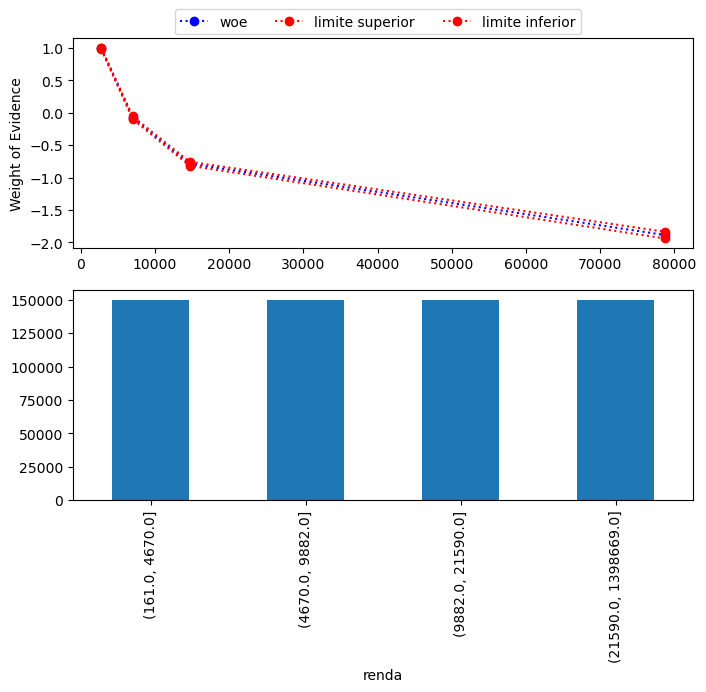

In [396]:
biv_continua('renda', 4, train)

Um WOE bem definido e que fica bem dentro dos limites, aqui não faremos mais mudanças.

A partir de agora, iremos inciar a criação do nosso modelo, lembrando que até aqui:
- *Removemos outliers em qtd_filhos deixando o limite para 5 e qtd_pessoas_residência para 7, além disso, estabelecemos um valor de renda como máximo a fim de não retirarmos mais de 0,1% dos dados do nosso df e por fim, trocamos os valores nulos de tempo de emprego para 40, uma vez que se referiam aos clientes aposentados.*

---

### MODELO

In [400]:
# ajuda para definir a equação da regressão
' + '.join(list(train.columns))

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom'

In [401]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda
'''

rl = smf.glm(formula, data=train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               599431
Model:                            GLM   Df Residuals:                   599405
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2483e+05
Date:                Wed, 05 Feb 2025   Deviance:                   2.4954e+05
Time:                        18:31:54   Pearson chi2:                 1.59e+16
No. Iterations:                    10   Pseudo R-squ. (CS):            0.04252
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.1368      0.193     -5.900      0.000      -1.514      -0.759
sexo[T.M]                           -0.1258      0.013     -9.584      0.000      -0.152      -0.100
posse_de_veiculo[T.S]                0.0312      0.012      2.521      0.012       0.007       0.055
posse_de_imovel[T.S]                -0.0842      0.012     -7.123      0.000      -0.107      -0.061
tipo_renda[T.Bolsista]               0.1154      0.300      0.384      0.701      -0.473       0.703
tipo_renda[T.Empresário]            -0.0521      0.014     -3.717      0.000      -0.080      -0.025
tipo_renda[T.Pensionista]            0.6598      0.062     10.714      0.000       0.539       0.781
tipo_renda[T.Servidor público]      -0.0331      0.023     -1.423      0.155      -0.079       0.012
educacao[T.Médio]                   -0.0313      0.049     -0.641      0.522      -0.127       0.064
educacao[T.Pós graduação]           -0.0439      0.168     -0.262      0.794      -0.373       0.285
educacao[T.Superior completo]       -0.0927      0.050     -1.862      0.063      -0.190       0.005
educacao[T.Superior incompleto]     -0.0802      0.056     -1.439      0.150      -0.189       0.029
estado_civil[T.Separado]            -0.0849      0.093     -0.918      0.359      -0.266       0.096
estado_civil[T.Solteiro]            -0.1163      0.091     -1.284      0.199      -0.294       0.061
estado_civil[T.União]                0.0484      0.020      2.378      0.017       0.008       0.088
estado_civil[T.Viúvo]               -0.1555      0.094     -1.652      0.099      -0.340       0.029
tipo_residencia[T.Casa]             -0.0901      0.044     -2.045      0.041      -0.176      -0.004
tipo_residencia[T.Com os pais]      -0.0731      0.050     -1.474      0.140      -0.170       0.024
tipo_residencia[T.Comunitário]      -0.1379      0.089     -1.542      0.123      -0.313       0.037
tipo_residencia[T.Estúdio]          -0.0351      0.082     -0.427      0.670      -0.197       0.126
tipo_residencia[T.Governamental]    -0.0860      0.053     -1.612      0.107      -0.190       0.019
qtd_filhos                           0.1245      0.090      1.388      0.165      -0.051       0.300
idade                                0.0001      0.001      0.180      0.857      -0.001       0.002
tempo_emprego                       -0.0220      0.002    -12.886      0.000      -0.025      -0.019
qt_pessoas_residencia               -0.1231      0.089     -1.376      0.169      -0.298       0.052
renda                               -0.0001   1.08e-06    -94.325      0.000      -0.000   -9.98e-05
====================================================================================================
"""

In [402]:
#ordenando o metadados pelo IV:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0.0,112368.0,covariavel,1.068628
tempo_emprego,float64,100875.0,3004.0,covariavel,0.351920
idade,int64,0.0,47.0,covariavel,0.017968
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
tipo_residencia,object,0.0,6.0,covariavel,0.003045
sexo,object,0.0,2.0,covariavel,0.002185
qtd_filhos,int64,0.0,6.0,covariavel,0.001631
qt_pessoas_residencia,float64,0.0,7.0,covariavel,0.001346


Vamos pegar todas que tem IV maior que 1%:

In [404]:
formula = '''
    mau ~ tempo_emprego + idade + renda
'''

rl = smf.glm(formula, data=train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               599431
Model:                            GLM   Df Residuals:                   599427
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2498e+05
Date:                Wed, 05 Feb 2025   Deviance:                   2.4984e+05
Time:                        18:31:58   Pearson chi2:                 1.94e+16
No. Iterations:                    10   Pseudo R-squ. (CS):            0.04203
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.7033      0.025    -67.852      0.000      -1.752      -1.654
tempo_emprego    -0.0039      0.001     -7.320      0.000      -0.005      -0.003
idade             0.0012      0.001      1.970      0.049    6.23e-06       0.002
renda            -0.0001   1.03e-06   -104.467      0.000      -0.000      -0.000
=================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

**Avaliação do Modelo na Base de Treino:**

In [407]:
#base de treino
train['score'] = rl.predict(train)

# Acurácia
acc = metrics.accuracy_score(train.mau, train.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(train.mau, train.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(train.loc[train.mau == 1, 'score'], train.loc[train.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 58.8% 
AUC: 76.9% 
GINI: 53.7%
KS: 39.7%


In [408]:
train.mau.value_counts(normalize=True)

mau
0    0.938904
1    0.061096
Name: proportion, dtype: float64

- A **Acurácia** de 58.8% é moderada, mas sozinha não é o melhor indicador, especialmente se o conjunto de dados for desbalanceado, *o que é o caso do nosso conjunto, onde quase 94% são bons e apenas 6,1% são maus.*

- O **AUC** de 76.9% e o **GINI** de 53.8% mostram que o modelo tem uma boa capacidade de distinguir entre as classes, o que é um bom sinal.

- O **KS** de 39.7% é um bom valor, indicando que o modelo tem uma boa capacidade de separar as classes em termos de distribuição acumulada.

**Avaliação do Modelo na Base de Teste:**

In [411]:
# Verificando nulos:
test.isnull().sum()

data_ref                     0
index                        0
sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            25082
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64

In [412]:
# Filtrando valores unicos de tipo de renda para emprego missing:
test.loc[test['tempo_emprego'].isna(), 'tipo_renda'].unique()

array(['Pensionista'], dtype=object)

In [413]:
# Substituindo os valores nulos por 40:
test['tempo_emprego']= test['tempo_emprego'].fillna(40)
test.isnull().sum()

C:\Users\charl\AppData\Local\Temp\ipykernel_10832\3211971396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['tempo_emprego']= test['tempo_emprego'].fillna(40)


data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

In [414]:
# Obter as previsões no conjunto de teste
test.loc[:, 'score'] = rl.predict(test)

# Acurácia
acc_test = metrics.accuracy_score(test.mau, test.score > 0.068)

# AUC
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(test.mau, test.score)
auc_test = metrics.auc(fpr_test, tpr_test)

# GINI
gini_test = 2 * auc_test - 1

# KS
ks_test = ks_2samp(test.loc[test.mau == 1, 'score'], test.loc[test.mau != 1, 'score']).statistic

# Imprimir as métricas para o conjunto de teste
print('Acurácia (Teste): {0:.1%} \nAUC (Teste): {1:.1%} \nGINI (Teste): {2:.1%} \nKS (Teste): {3:.1%}'
      .format(acc_test, auc_test, gini_test, ks_test))

Acurácia (Teste): 30.1% 
AUC (Teste): 73.3% 
GINI (Teste): 46.5% 
KS (Teste): 33.8%


C:\Users\charl\AppData\Local\Temp\ipykernel_10832\1496153047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'score'] = rl.predict(test)


In [415]:
test.mau.value_counts(normalize=True)

mau
False    0.853333
True     0.146667
Name: proportion, dtype: float64

- A **Acurácia** de 30.1% é relativamente baixa, o que indica que o modelo está acertando apenas uma pequena parte das previsões. No entanto, em problemas desbalanceados, a acurácia pode ser uma métrica enganosa.
- Novamente, o **GINI**,  **AUC** e **KS** indicam que o modelo está conseguindo distinguir entre as classes, mas ainda com um desempenho razoável, menor que para a base de treino.

